## Prediction of Traffic Volume

<img src="traffic_sidebar.jpg" width=500 height = 280/>

Following is the description of columns in `Traffic_Volume.csv` file:

| Variable             | Description                                               |
|----------------------|-----------------------------------------------------------|
| holiday              | US National holidays plus regional holiday                |
| temp                 | Average temperature in Kelvin                             |
| rain_1h              | Amount in mm of rain that occurred in the hour            |
| snow_1h              | Amount in mm of snow that occurred in the hour            |
| clouds_all           | Percentage of cloud cover                                 |
| weather_main         | Short textual description of the current weather          |
| date_time            | Date and hour of the data collected in local CST time     |
| traffic_volume (outcome) | Hourly I-94 ATR 301 reported westbound traffic volume |



### AI disclosure: 
Tool: ChatGPT-5; Copilot.

Purpose: Brainstorm re-run when aplha slider is changed; Idea for min/max under slider; 
        Guidance on imports and libomp path for M1 Mac; Guidance on XGBoost import; 
        Brainstorm encoding for datetime features; Debug one-hot endoing. 

Usage: Html code for titles; Implemented session state for alpha slider; ctypes libomp load line; 
        XGBoost import line; Used pd.to_datetime but corrected ChatGPT suggestion to our project; .
        
Location: Documented here and in app.py comments (top of file).

### Import Libraries

In [144]:
!pip install mapie==0.9.1





[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [ ]:
""" AI disclosure: 
Tool: ChatGPT-5 
Purpose: Guidance on imports and libomp path for M1 Mac; Guidance on XGBoost import.   
Usage: ctypes libomp load line; XGBoost import line.
Location: Documented here and in app.py comments (top of file)."""

import pandas as pd                  # Pandas
import numpy as np                   # Numpy
from matplotlib import pyplot as plt # Matplotlib
import ctypes
ctypes.CDLL("/opt/homebrew/opt/libomp/lib/libomp.dylib")

# Package to implement ML Algorithms
import sklearn
from xgboost import XGBRegressor

# Import MAPIE to calculate prediction intervals
from mapie.regression import MapieRegressor

# To calculate coverage score
from mapie.metrics import regression_coverage_score

# Package for data partitioning
from sklearn.model_selection import train_test_split

# Package to record time
import time

# Module to save and load Python objects to and from files
import pickle 

# Ignore Deprecation Warnings
import warnings
warnings.filterwarnings('ignore')

# Display inline plots as vector-based (svg)
%config InlineBackend.figure_formats = ['svg']

%matplotlib inline

**Install MAPIE via `pip`**:

`!pip install mapie`

### Load Dataset

In [146]:
# Import Data
df = pd.read_csv('Traffic_Volume.csv')
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,10/2/12 9:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,10/2/12 10:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,10/2/12 11:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,10/2/12 12:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,10/2/12 13:00,4918


In [ ]:
""" AI disclosure: 
Tool: ChatGPT-5 
Purpose: Brainstormed encoding for datetime features.
Usage: Used pd.to_datetime but corrected ChatGPT suggestion to our project.
Location: Documented here and in app.py comments (top of file)."""

# Select input and output features
X = df.drop(columns = ['traffic_volume'])
y = df["traffic_volume"]
X["date_time"] = pd.to_datetime(X["date_time"], errors="coerce")
X["hour"] = X["date_time"].dt.hour
X["weekday"] = X["date_time"].dt.day_name()
X["month"] = X["date_time"].dt.month_name()

X = X.drop(columns = ['date_time'])



In [148]:
# Save the raw feature dataframe (before encoding)
X.to_csv("traffic_volume_raw.csv", index=False)

In [149]:
# One-hot the remaining object columns
categorical_cols = ["holiday", "weather_main", "weekday", "month"]
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

X_encoded = X_encoded.astype('float32')

X_encoded.head()

list(X_encoded.columns)

# AI disclousure: The above code was generated with the assistance of ChatGPT-5

['temp',
 'rain_1h',
 'snow_1h',
 'clouds_all',
 'hour',
 'holiday_Columbus Day',
 'holiday_Independence Day',
 'holiday_Labor Day',
 'holiday_Martin Luther King Jr Day',
 'holiday_Memorial Day',
 'holiday_New Years Day',
 'holiday_State Fair',
 'holiday_Thanksgiving Day',
 'holiday_Veterans Day',
 'holiday_Washingtons Birthday',
 'weather_main_Clouds',
 'weather_main_Drizzle',
 'weather_main_Fog',
 'weather_main_Haze',
 'weather_main_Mist',
 'weather_main_Rain',
 'weather_main_Smoke',
 'weather_main_Snow',
 'weather_main_Squall',
 'weather_main_Thunderstorm',
 'weekday_Monday',
 'weekday_Saturday',
 'weekday_Sunday',
 'weekday_Thursday',
 'weekday_Tuesday',
 'weekday_Wednesday',
 'month_August',
 'month_December',
 'month_February',
 'month_January',
 'month_July',
 'month_June',
 'month_March',
 'month_May',
 'month_November',
 'month_October',
 'month_September']

In [150]:
# Data partitioning into train and test sets
train_X, test_X, train_y, test_y = train_test_split(X_encoded, y, test_size = 0.2, random_state = 42)

### Implement XGBoost model

In [ ]:
# Define the XGBoost model
xgb = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=2000,          
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    n_jobs=-1,
    random_state=42,
)

In [152]:
# Fit the model
start = time.time()            # Start Time
xgb.fit(train_X, train_y)
stop = time.time()             # Stop Time
print(f"Training Time: {stop - start} seconds")

Training Time: 3.489744186401367 seconds


#### Evaluate Prediction Performance on Test Set

In [153]:
# Predict Test Set
y_pred = xgb.predict(test_X)

# Evaluate the model on test set
r2 = sklearn.metrics.r2_score(test_y, y_pred)
print('R-squared on Test Set: %0.2f' %r2)

RMSE_test = sklearn.metrics.root_mean_squared_error(test_y, y_pred)
print('RMSE on Test Set: %0.2f' %RMSE_test)

R-squared on Test Set: 0.96
RMSE on Test Set: 410.98


In [154]:
# Predict Training Set
y_pred = xgb.predict(train_X)

# Evaluate the model on test set
r2 = sklearn.metrics.r2_score(train_y, y_pred)
print('R-squared on Training Set: %0.2f' %r2)

RMSE_test = sklearn.metrics.root_mean_squared_error(train_y, y_pred)
print('RMSE on Training Set: %0.2f' %RMSE_test)

R-squared on Training Set: 0.98
RMSE on Training Set: 289.39


#### Histogram of Residuals/Errors 

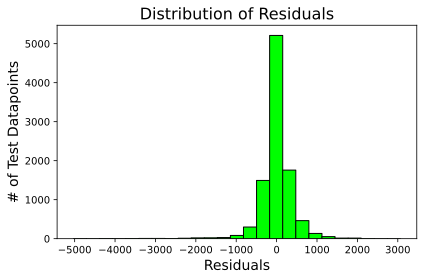

In [172]:
# Calculate the residuals by subtracting the predicted values from the actual test value
y_pred = xgb.predict(test_X)
all_residuals = test_y - y_pred

# Set up the figure with custom size and resolution (DPI)
plt.figure(figsize=(6, 4), dpi = 150)

# Plot the histogram of residuals
plt.hist(all_residuals, bins = 25, color = 'lime', edgecolor = 'black')

# Label X and Y axes
plt.xlabel('Residuals', fontsize = 14)
plt.ylabel('# of Test Datapoints', fontsize = 14)

# Set the title of the plot
plt.title('Distribution of Residuals', fontsize = 16)

# Adjust the font size of x and y ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

# Save the figure
plt.tight_layout()
plt.savefig('histogram_of_residuals.png', dpi = 300)



#### Scatter Plot of Predicted Vs. Actual Values

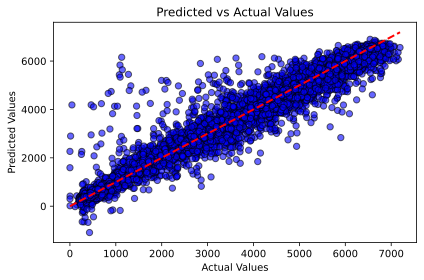

In [174]:
# Setting the figure size and resolution
plt.figure(figsize = (6, 4), dpi = 150)

# Scatter plot of actual vs predicted values
plt.scatter(test_y, y_pred, color = 'blue', alpha = 0.6, edgecolor = 'black', s = 40)

# 45-degree reference line (perfect predictions)
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color = 'red', linestyle = '--', lw = 2)

# Axis labels and title
plt.xlabel('Actual Values', fontsize = 10)
plt.ylabel('Predicted Values', fontsize = 10)
plt.title('Predicted vs Actual Values', fontsize = 12)

# Adjust ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

# Saving the figure
plt.tight_layout()
plt.savefig('predicted_vs_actual.png', dpi = 300)

#### Feature Importance Plot

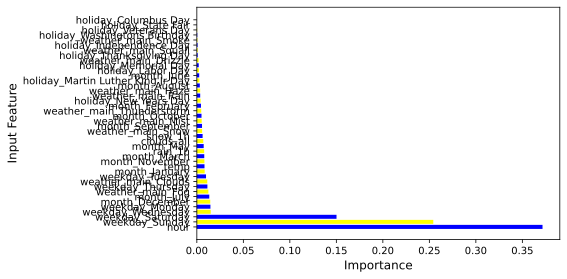

In [173]:
# Storing importance values from the trained model
importance = xgb.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Bar plot
plt.figure(figsize=(8, 4))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['blue', 'yellow'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.yticks(fontsize = 10) # fontsize of yticks
plt.xticks(fontsize = 10) # fontsize of xticks

# Save the figure
plt.tight_layout()
plt.savefig('feature_importance.png', dpi = 300)

### Prediction Intervals for Regression

#### **Prediction Intervals using MAPIE Regressor**

***MAPIE: Model Agnostic Prediction Interval Estimator***

- It is a Python library designed to estimate prediction intervals in a **model-agnostic way**.
- It can be used with **any machine learning model**, including linear models, decision trees, ensemble methods, and neural networks.

In [158]:
import os
os.cpu_count()

8

In [159]:
# Define MAPIE regressor
mapie = MapieRegressor(estimator = xgb, # Prediction model to use
                       n_jobs = -1, # Parallell processing, any laptop has differnet amount of CPU, use -1 to use all available cores
                       random_state = 42)

# Fit mapie regressor on training data
start = time.time()  
mapie.fit(train_X, train_y)
stop = time.time()             
print(f"Training time: {stop - start}s")

alpha = 0.1 # For 90% confidence level

# Use mapie.predict() to get predicted values and intervals
        # y_test_pred will give point predictions
        # y_test_pis will give prediction intervals
        # The width of the prediction intervals is determined by the alpha value
y_test_pred, y_test_pis = mapie.predict(test_X, alpha = alpha)

Training time: 11.396813154220581s


In [160]:
# Predicted values
y_test_pred

# Preditctions of students change to getting admitted

array([5465.914 , 2152.6787,  700.9295, ..., 2243.8867, 2819.139 ,
        632.0109], shape=(9641,), dtype=float32)

In [161]:
# Prediction Intervals
y_test_pis

# For each student we have the lowest and highest predicted chance of getting admitted
# For example, for the first student in the test set, we are 90% confident that their chance of getting admitted is between 0.58 and 0.87

array([[[4973.60595703],
        [6174.5078125 ]],

       [[1554.1340332 ],
        [2687.91143799]],

       [[ 130.32037354],
        [1254.38104248]],

       ...,

       [[1638.66894531],
        [2779.93554688]],

       [[2302.85205078],
        [3439.5612793 ]],

       [[  86.30072021],
        [1209.32244873]]], shape=(9641, 2, 1))

In [162]:
# Storing results in a dataframe
predictions = test_y.to_frame()
predictions.columns = ['Actual Value']
predictions["Predicted Value"] = y_test_pred.round(2)
predictions["Lower Value"] = y_test_pis[:, 0].round(2)
predictions["Upper Value"] = y_test_pis[:, 1].round(2)

# Take a quick look
predictions.tail(5)

,Actual Value,Predicted Value,Lower Value,Upper Value
6401,2491,2556.929932,2067.13,3209.89
34004,5251,5246.540039,4739.42,5862.35
46086,2224,2243.889893,1638.67,2779.94
42579,2928,2819.139893,2302.85,3439.56
23709,910,632.010010,86.30,1209.32


### **Coverage Calculation**
- **Coverage** refers to the proportion of true/actual values that fall within the prediction intervals generated by a model.

- It is a measure of how well the prediction intervals capture the actual values.

  $\text{Coverage} = \frac{\text{Number of actual values within prediction intervals}}{\text{Total number of actual values}}$

In [163]:
coverage = regression_coverage_score(test_y,           # Actual values
                                     y_test_pis[:, 0], # Lower bound of prediction intervals
                                     y_test_pis[:, 1]) # Upper bound of prediction intervals

coverage_percentage = coverage * 100
print(f"Coverage: {coverage_percentage:.2f}%")

Coverage: 91.73%


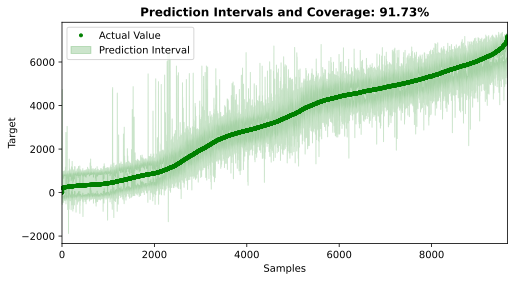

In [164]:
# Sort the predictions by 'Actual Value' for better visualization and reset the index
sorted_predictions = predictions.sort_values(by=['Actual Value']).reset_index(drop=True)

# Create a figure and axis object with specified size and resolution
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the actual values with green dots
plt.plot(sorted_predictions["Actual Value"], 'go', markersize=3, label="Actual Value")

# Fill the area between the lower and upper bounds of the prediction intervals with semi-transparent green color
plt.fill_between(np.arange(len(sorted_predictions)),
                 sorted_predictions["Lower Value"],
                 sorted_predictions["Upper Value"],
                 alpha=0.2, color="green", label="Prediction Interval")

# Set font size for x and y ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Set the limit for the x-axis to cover the range of samples
plt.xlim([0, len(sorted_predictions)])

# Label the x-axis and y-axis with appropriate font size
plt.xlabel("Samples", fontsize=10)
plt.ylabel("Target", fontsize=10)

# Add a title to the plot, including the coverage percentage, with bold formatting
plt.title(f"Prediction Intervals and Coverage: {coverage_percentage:.2f}%", fontsize=12, fontweight="bold")

# Add a legend to the plot, placed in the upper left, with specified font size
plt.legend(loc="upper left", fontsize=10);

# Save the figure
plt.savefig('coverage_plot.png', dpi = 300)

### Save Model

In [165]:
# Creating the file where we want to write the model
traffic_volume_pickle = open('traffic_volume.pickle', 'wb') 

# Write RF model to the file
pickle.dump(mapie, traffic_volume_pickle) 

# Close the file
traffic_volume_pickle.close()